In [7]:
import torch
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import diptest
import seaborn as sns
import random

In [8]:
from scipy.stats import dirichlet
from scipy.stats import multinomial
from scipy.stats import poisson
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import multivariate_normal

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [11]:
import pickle

In [12]:
torch.cuda.set_device(1)

# conf model

In [62]:
def fit_DM(X, M, learning_rate=0.01, num_epochs=3000, threshold = 0.001, print_process = False):
    # setting variables
    x = torch.from_numpy(X)
    M = torch.from_numpy(M)
    alpha = (torch.sum(x,axis=0)/torch.sum(torch.sum(x,axis=0))).clone().detach().requires_grad_(True)
    optimizer = optim.Adam([alpha], lr=learning_rate)
    # optimizing
    loss_last = 0
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        aa = torch.relu(alpha)
        loss = -torch.sum(torch.lgamma(torch.sum(M*aa,dim=1)) - torch.lgamma(torch.sum(x + M*aa,dim=1)) +  torch.sum(torch.lgamma(aa + x)*M - torch.lgamma(aa)*M,dim=1))
        loss.backward()
        optimizer.step()
        if print_process:
            if epoch % 50 == 0:
                print(alpha)
        if np.abs(loss.detach().numpy()-loss_last)<=threshold:
            break
        else:
            loss_last=loss.detach().numpy()
    return torch.relu(alpha)

In [63]:
def generat_data_DM(alpha,M,Beta,n_samples,lambda_poisson,add_noise=True, gaussian_noise_parameter=0.05):
    vectors_p = np.array([dirichlet.rvs(alpha + norm.rvs(0,alpha/100),size=1) for x in range(n_samples)]).squeeze()
    vectors_N = np.apply_along_axis(lambda x: multinomial.rvs(n=poisson.rvs(lambda_poisson), p=x),axis=1,arr= vectors_p)
    # filtering
    for i in range(n_samples):
        N_i = vectors_N[i]
        M_i = M[i]
        vectors_N[i] = np.array([binom.rvs(N_i[j],0.01+0.98*M_i[j]) for j in range(len(alpha))])
    ## multinucleated cells
    vectors_N = vectors_N*Beta
    ## add Gaussian noise 
    if add_noise:
        sigma_noise = np.eye(vectors_N.shape[1])
        for i in range(n_samples):
            for j in range(vectors_N.shape[1]):
                sigma_noise[j,j] = vectors_N[i,j]*gaussian_noise_parameter
            vectors_N[i] = vectors_N[i] + multivariate_normal.rvs(np.zeros(vectors_N.shape[1]),sigma_noise,size=1).astype(np.int8)
    return vectors_N

In [64]:
def generat_data_MVN(miu,sigma,M,Beta,n_samples,lambda_poisson,add_noise = True, gaussian_noise_parameter=0.05):
    vectors_p = np.array([multivariate_normal.rvs(np.log(miu),sigma,size=1) for x in range(n_samples)]).squeeze()
    vectors_p = np.apply_along_axis(lambda x: np.exp(x)/np.exp(x).sum() ,axis=1,arr= vectors_p)# softmax
    vectors_N = np.apply_along_axis(lambda x: multinomial.rvs(n=poisson.rvs(lambda_poisson), p=x),axis=1,arr= vectors_p)
    ## filtering
    for i in range(n_samples):
        N_i = vectors_N[i]
        M_i = M[i]
        vectors_N[i] = np.array([binom.rvs(N_i[j],0.01+0.98*M_i[j]) for j in range(len(miu))])
        
    ## multinucleated cells
    vectors_N = vectors_N*Beta
    ## add Gaussian noise
    if add_noise:
        sigma_noise = np.eye(vectors_N.shape[1])
        for i in range(n_samples):
            for j in range(vectors_N.shape[1]):
                sigma_noise[j,j] = vectors_N[i,j]*gaussian_noise_parameter
            vectors_N[i] = vectors_N[i] + multivariate_normal.rvs(np.zeros(vectors_N.shape[1]),sigma_noise,size=1).astype(np.int8)
    return vectors_N

In [19]:
def mean_corrcoef(x,y):
    coefs = np.array([np.corrcoef(x[i],y[i])[0,1] for i in range(x.shape[0])])
    return coefs.mean()

# 0. construct pipeline

In [406]:
u = np.array([0.3,0.1,0.1,0.1,0.2,0.15,0.05])
alpha = u*10
M = np.ones((100,7))
Beta = np.ones((100,7))

sigma = np.eye(7)
for i in range(7):
    #sigma[i,i] = u[i]*(1-u[i])/(alpha.sum()+1)
    sigma[i,i] = abs(np.log(u[i])*0.1)

## MVN generation model

In [407]:
df_simu2 = pd.DataFrame(generat_data_MVN(alpha,sigma,M,Beta,n_samples=100, lambda_poisson = 5000,add_noise=True))

(0.0, 8.0, 0.0, 1.0)

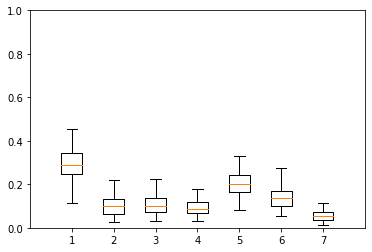

In [408]:
df_simu2_prop = pd.DataFrame([df_simu2.loc[i,:]/df_simu2.loc[i,:].sum() for i in range(100)])
plt.boxplot(df_simu2_prop,sym  ='' )
plt.axis([0,8,0,1])

In [409]:
alpha_result = fit_DM(np.array(df_simu2),M)
prop_DM = (alpha_result/torch.sum(alpha_result)).detach().numpy()
prop_DM

array([0.28631065, 0.10419292, 0.10849706, 0.09831042, 0.19996967,
       0.14196982, 0.06074946])

In [410]:
prop_direct = np.array(df_simu2.sum(axis=0)/df_simu2.sum(axis=0).sum())
prop_direct

array([0.29307436, 0.10307349, 0.10784463, 0.09527079, 0.20356093,
       0.14192502, 0.05525078])

In [411]:
np.corrcoef(u,prop_DM)[0,1]

0.9980296749631778

In [412]:
np.corrcoef(u,prop_direct)[0,1]

0.997707937883827

# 1. generate data without filtering and multinucleated

Randomize 50 alpha vectors as 50 reference proportions and generate 50 samples without filtering and multinucleated cells for each alpha vector. Calculate the MAE, MSE and the correlation between estimated proportions and reference proportions.

## 1.1 different gaussian_noise

In [356]:
props_reference = np.zeros([50,7,7])
props_DM = np.zeros([50,7,7])
props_mean = np.zeros([50,7,7])
props_sum = np.zeros([50,7,7])

M = np.ones((50,7))
Beta = np.ones((50,7))

GNP = np.array([0.05,0.1,0.2,0.5,1,2])

for j in range(6):
    gnp = GNP[j]
    for epoch in range(50):
        # Generate reference proportions and covariance matrix
        u = np.array(random.sample(range(1,20),7))
        u = np.array(u/u.sum())
        props_reference[epoch,:,j+1] = u

        sigma = np.eye(7)
        for i in range(7):
            sigma[i,i] = abs(np.log(u[i])*0.1)
        # Generate data
        data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=gnp)

        # Estimate proportion with DM
        alpha_result = fit_DM(data_simu,M)
        props_DM[epoch,:,j+1] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

        # directly calculate proportion
        props_mean[epoch,:,j+1] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
        props_sum[epoch,:,j+1] = data_simu.sum(axis=0)/data_simu.sum().sum()
        
for epoch in range(50):
    # Generate reference proportions and covariance matrix
    u = np.array(random.sample(range(1,20),7))
    u = np.array(u/u.sum())
    props_reference[epoch,:,0] = u

    sigma = np.eye(7)
    for i in range(7):
        sigma[i,i] = abs(np.log(u[i])*0.1)
    # Generate data
    data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,add_noise=False)

    # Estimate proportion with DM
    alpha_result = fit_DM(data_simu,M)
    props_DM[epoch,:,0] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

    # directly calculate proportion
    props_mean[epoch,:,0] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
    props_sum[epoch,:,0] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [363]:
with open('ExperimentResult/EX1/Gaussian_noise/props.reference.pkl', 'wb') as f:
    pickle.dump(props_reference, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.DM.pkl', 'wb') as f:
    pickle.dump(props_DM, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.mean.pkl', 'wb') as f:
    pickle.dump(props_mean, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.sum.pkl', 'wb') as f:
    pickle.dump(props_sum, f)

In [44]:
with open('ExperimentResult/EX1/Gaussian_noise/props.reference.pkl', 'rb') as f:
    props_reference = pickle.load(f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.DM.pkl', 'rb') as f:
    props_DM = pickle.load(f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.mean.pkl', 'rb') as f:
    props_mean = pickle.load(f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.sum.pkl', 'rb') as f:
    props_sum = pickle.load(f)
    
GNP = np.array([0.05,0.1,0.2,0.5,1,2])

In [45]:
MAE_DM_list = np.array([mean_absolute_error(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
MAE_mean_list = np.array([mean_absolute_error(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
MAE_sum_list = np.array([mean_absolute_error(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

In [46]:
MSE_DM_list = np.array([mean_squared_error(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
MSE_mean_list = np.array([mean_squared_error(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
MSE_sum_list = np.array([mean_squared_error(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

In [47]:
corrcoef_DM_list = np.array([mean_corrcoef(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
corrcoef_mean_list = np.array([mean_corrcoef(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
corrcoef_sum_list = np.array([mean_corrcoef(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

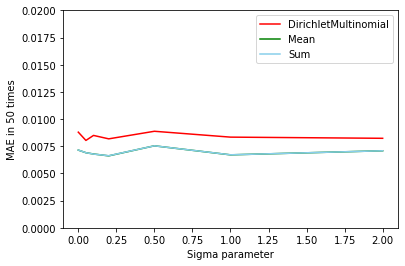

In [48]:
plt.figure()
plt.plot(np.concatenate([np.array([0]),GNP]), MAE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(np.concatenate([np.array([0]),GNP]), MAE_mean_list, color='green', label='Mean')
plt.plot(np.concatenate([np.array([0]),GNP]), MAE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.ylim(0,0.02)
plt.xlabel('Sigma parameter')
plt.ylabel('MAE in 50 times')
plt.savefig("ExperimentResult/EX1/Gaussian_noise/MAE.pdf",dpi=300)

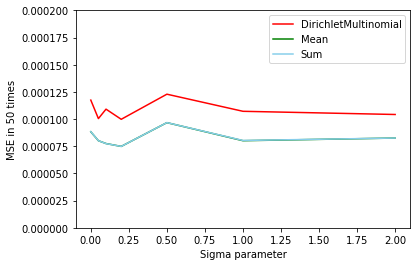

In [49]:
plt.figure()
plt.plot(np.concatenate([np.array([0]),GNP]), MSE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(np.concatenate([np.array([0]),GNP]), MSE_mean_list, color='green', label='Mean')
plt.plot(np.concatenate([np.array([0]),GNP]), MSE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.ylim(0,0.0002)
plt.xlabel('Sigma parameter')
plt.ylabel('MSE in 50 times')
plt.savefig("ExperimentResult/EX1/Gaussian_noise//MSE.pdf",dpi=300)

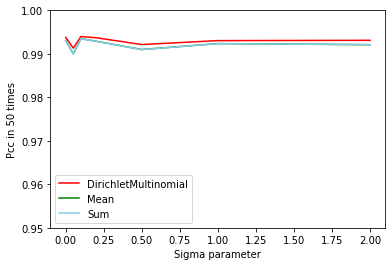

In [50]:
plt.figure()
plt.plot(np.concatenate([np.array([0]),GNP]), corrcoef_DM_list, color='red', label='DirichletMultinomial')
plt.plot(np.concatenate([np.array([0]),GNP]), corrcoef_mean_list, color='green', label='Mean')
plt.plot(np.concatenate([np.array([0]),GNP]), corrcoef_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.ylim(0.95,1)
plt.xlabel('Sigma parameter')
plt.ylabel('Pcc in 50 times')
plt.savefig("ExperimentResult/EX1/Gaussian_noise/Corrcoef.pdf",dpi=300)

In [363]:
with open('ExperimentResult/EX1/Gaussian_noise/props.reference.pkl', 'wb') as f:
    pickle.dump(props_reference, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.DM.pkl', 'wb') as f:
    pickle.dump(props_DM, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.mean.pkl', 'wb') as f:
    pickle.dump(props_mean, f)
    
with open('ExperimentResult/EX1/Gaussian_noise/props.sum.pkl', 'wb') as f:
    pickle.dump(props_sum, f)

## 1.2 different sigma

In [389]:
props_reference = np.zeros([50,7,7])
props_DM = np.zeros([50,7,7])
props_mean = np.zeros([50,7,7])
props_sum = np.zeros([50,7,7])

M = np.ones((50,7))
Beta = np.ones((50,7))

Sigma_parameter = np.array([0.05,0.1,0.2,0.5,1.0,2.0,5.0])

for j in range(7):
    sp = Sigma_parameter[j]
    for epoch in range(50):
        # Generate reference proportions and covariance matrix
        u = np.array(random.sample(range(1,20),7))
        u = np.array(u/u.sum())
        props_reference[epoch,:,j] = u

        sigma = np.eye(7)
        for i in range(7):
            sigma[i,i] = abs(np.log(u[i])*sp)
        # Generate data
        data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=0.05)

        # Estimate proportion with DM
        alpha_result = fit_DM(data_simu,M)
        props_DM[epoch,:,j] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

        # directly calculate proportion
        props_mean[epoch,:,j] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
        props_sum[epoch,:,j] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [52]:
with open('ExperimentResult/EX1/Sigma/props.reference.pkl', 'rb') as f:
    props_reference = pickle.load(f)
    
with open('ExperimentResult/EX1/Sigma/props.DM.pkl', 'rb') as f:
    props_DM = pickle.load(f)
    
with open('ExperimentResult/EX1/Sigma/props.mean.pkl', 'rb') as f:
    props_mean = pickle.load(f)
    
with open('ExperimentResult/EX1/Sigma/props.sum.pkl', 'rb') as f:
    props_sum = pickle.load(f)
    
Sigma_parameter = np.array([0.05,0.1,0.2,0.5,1.0,2.0,5.0])


In [53]:
MAE_DM_list = np.array([mean_absolute_error(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
MAE_mean_list = np.array([mean_absolute_error(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
MAE_sum_list = np.array([mean_absolute_error(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

In [54]:
MSE_DM_list = np.array([mean_squared_error(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
MSE_mean_list = np.array([mean_squared_error(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
MSE_sum_list = np.array([mean_squared_error(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

In [55]:
corrcoef_DM_list = np.array([mean_corrcoef(props_reference[:,:,i],props_DM[:,:,i]) for i in range(7)])
corrcoef_mean_list = np.array([mean_corrcoef(props_reference[:,:,i],props_mean[:,:,i]) for i in range(7)])
corrcoef_sum_list = np.array([mean_corrcoef(props_reference[:,:,i],props_sum[:,:,i]) for i in range(7)])

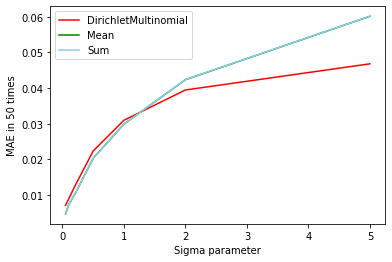

In [57]:
plt.figure()
plt.plot(Sigma_parameter, MAE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(Sigma_parameter, MAE_mean_list, color='green', label='Mean')
plt.plot(Sigma_parameter, MAE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.xlabel('Sigma parameter')
plt.ylabel('MAE in 50 times')
plt.savefig("ExperimentResult/EX1/Sigma/MAE.pdf",dpi=300)

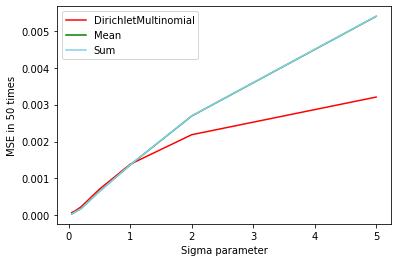

In [58]:
plt.figure()
plt.plot(Sigma_parameter, MSE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(Sigma_parameter, MSE_mean_list, color='green', label='Mean')
plt.plot(Sigma_parameter, MSE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.xlabel('Sigma parameter')
plt.ylabel('MSE in 50 times')
plt.savefig("ExperimentResult/EX1/Sigma/MSE.pdf",dpi=300)

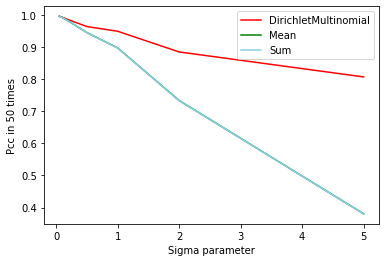

In [60]:
plt.figure()
plt.plot(Sigma_parameter, corrcoef_DM_list, color='red', label='DirichletMultinomial')
plt.plot(Sigma_parameter, corrcoef_mean_list, color='green', label='Mean')
plt.plot(Sigma_parameter, corrcoef_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.xlabel('Sigma parameter')
plt.ylabel('Pcc in 50 times')
plt.savefig("ExperimentResult/EX1/Sigma/Corrcoef.pdf",dpi=300)

In [403]:
with open('ExperimentResult/EX1/Sigma/props.reference.pkl', 'wb') as f:
    pickle.dump(props_reference, f)
    
with open('ExperimentResult/EX1/Sigma/props.DM.pkl', 'wb') as f:
    pickle.dump(props_DM, f)
    
with open('ExperimentResult/EX1/Sigma/props.mean.pkl', 'wb') as f:
    pickle.dump(props_mean, f)
    
with open('ExperimentResult/EX1/Sigma/props.sum.pkl', 'wb') as f:
    pickle.dump(props_sum, f)

# 2. generate data with filtering

## 2.1 random experiment


Randomize 50 alpha vectors as 50 reference proportions and generate 50 samples without filtering for each alpha vector. Calculate the MAE, MSE and the correlation between estimated proportions and reference proportions.

The first 10 sample without filtering, the next 20 samples filtered out the first three cell types, the last 20 samples filtered out the last three cell types.

In [239]:
props_reference = np.zeros([50,7])
props_DM = np.zeros([50,7])
props_mean = np.zeros([50,7])
props_sum = np.zeros([50,7])

M = np.ones((50,7))
M[10:30,0:3] = 0
M[30:50,4:7] = 0

Beta = np.ones((50,7))

for epoch in range(50):
    # Generate reference proportions and covariance matrix
    u = np.array(random.sample(range(1,20),7))
    u = np.array(u/u.sum())
    props_reference[epoch,:] = u
    
    sigma = np.eye(7)
    for i in range(7):
        sigma[i,i] = abs(np.log(u[i])*0.5)
    # Generate data
    data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=0.05)
    
    # Estimate proportion with DM
    alpha_result = fit_DM(data_simu,M)
    props_DM[epoch,:] = (alpha_result/torch.sum(alpha_result)).detach().numpy()
    
    # directly calculate proportion
    props_mean[epoch,:] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
    props_sum[epoch,:] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [240]:
print("MAE of Dirichlet-Multinomial model results：",mean_absolute_error(props_reference,props_DM))
print("MAE of mean proportions：",mean_absolute_error(props_reference,props_mean))
print("MAE of sum count proportion：",mean_absolute_error(props_reference,props_sum))

MAE of Dirichlet-Multinomial model results： 0.02209827421864641
MAE of mean proportions： 0.03457068849861668
MAE of sum count proportion： 0.02813359161328331


In [241]:
print("MSE of Dirichlet-Multinomial model results：",mean_squared_error(props_reference,props_DM))
print("MSE of mean proportions：",mean_squared_error(props_reference,props_mean))
print("MSE of sum count proportion：",mean_squared_error(props_reference,props_sum))

MSE of Dirichlet-Multinomial model results： 0.0007228683671800115
MSE of mean proportions： 0.002028620630626092
MSE of sum count proportion： 0.0014164670974473523


In [242]:
print("correlation of Dirichlet-Multinomial model results：",mean_corrcoef(props_reference,props_DM))
print("correlation of mean proportions：",mean_corrcoef(props_reference,props_mean))
print("correlation of sum count proportion：",mean_corrcoef(props_reference,props_sum))

correlation of Dirichlet-Multinomial model results： 0.9409983677109401
correlation of mean proportions： 0.7458823719540739
correlation of sum count proportion： 0.8171928039241553


## 2.2 filtering result on high-abundance cell-type

In [98]:
u = np.array([0.7,0.05,0.05,0.05,0.05,0.05,0.05])# The first cell type will be filtered
M = np.ones((50,7))
M[0:30,0] = 0
Beta = np.ones((50,7))

sigma = np.eye(7)
for i in range(7):
    sigma[i,i] = abs(np.log(u[i])*0.5)

props_DM = np.zeros([50,7])
props_mean = np.zeros([50,7])
props_sum = np.zeros([50,7])
for epoch in range(50):
    data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=0.05)

    # Estimate proportion with DM
    alpha_result = fit_DM(data_simu,M,)
    props_DM[epoch,:] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

    # directly calculate proportion
    props_mean[epoch,:] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
    props_sum[epoch,:] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [99]:
data_simu_prop = data_simu
for i in range(50):
    data_simu_prop[i,:] = data_simu_prop[i,:]/sum(data_simu_prop[i,:])

([<matplotlib.axis.XTick at 0x7f5520560430>,
 [Text(1, 0, 'ct1'),
  Text(2, 0, 'ct2'),
  Text(3, 0, 'ct3'),
  Text(4, 0, 'ct4'),
  Text(5, 0, 'ct5'),
  Text(6, 0, 'ct6'),
  Text(7, 0, 'ct7')])

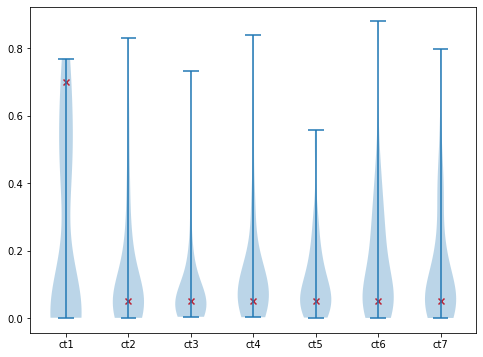

In [100]:
plt.figure(figsize=(8,6))
plt.scatter(x=[1,2,3,4,5,6,7], y= u,c="red",marker="x")
plt.violinplot(data_simu_prop)
plt.xticks([1,2,3,4,5,6,7],["ct"+str(i+1) for i in range(7)])


In [101]:
df_props_DM = pd.DataFrame(props_DM)
df_props_DM.columns = np.array(["ct"+str(i+1) for i in range(7)])

df_props_mean = pd.DataFrame(props_mean)
df_props_mean.columns = np.array(["ct"+str(i+1) for i in range(7)])

df_props_sum = pd.DataFrame(props_sum)
df_props_sum.columns = np.array(["ct"+str(i+1) for i in range(7)])

tmp = (pd.concat([d.assign(data=i)                       # assign adds the column `data` with values i
                    for i,d in enumerate([df_props_DM,df_props_mean,df_props_sum])]  # enumerate gives you a generator of pairs (0,df), (1,df1), (2,df2)
                )
         .melt(id_vars='data')                           # melt basically turns `id_vars` columns into index, 
                                                         # and stacks other columns
      )
tmp.loc[tmp.data==0,'data']="D-M"
tmp.loc[tmp.data==1,'data']="Mean"
tmp.loc[tmp.data==2,'data']="Sum"

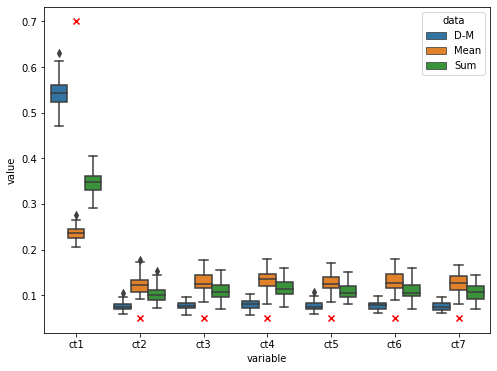

In [102]:
plt.figure(figsize=(8,6))
sns.boxplot(data=tmp, x='variable', hue='data', y='value')
plt.scatter(x=["ct"+str(i+1) for i in range(7)], y= u,c="red",marker="x")
plt.savefig("ExperimentResult/EX2/abundance/high.abundance.pdf",dpi=300)

In [103]:
props_reference = np.array([u for _ in range(50)])

print("correlation of Dirichlet-Multinomial model results：",mean_corrcoef(props_reference,props_DM))
print("correlation of mean proportions：",mean_corrcoef(props_reference,props_mean))
print("correlation of sum count proportion：",mean_corrcoef(props_reference,props_sum))

correlation of Dirichlet-Multinomial model results： 0.9990561152721901
correlation of mean proportions： 0.8943256225545576
correlation of sum count proportion： 0.9780573071823152


## 2.3 filtering result on low-abundance cell-type

In [90]:
u = np.array([0.04,0.16,0.16,0.16,0.16,0.16,0.16])# The first cell type will be filtered
M = np.ones((50,7))
M[0:30,0] = 0
Beta = np.ones((50,7))

sigma = np.eye(7)
for i in range(7):
    sigma[i,i] = abs(np.log(u[i])*0.05)

props_DM = np.zeros([50,7])
props_mean = np.zeros([50,7])
props_sum = np.zeros([50,7])
for epoch in range(50):
    data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=0.05)

    # Estimate proportion with DM
    alpha_result = fit_DM(data_simu,M)
    props_DM[epoch,:] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

    # directly calculate proportion
    props_mean[epoch,:] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
    props_sum[epoch,:] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [91]:
data_simu_prop = data_simu
for i in range(50):
    data_simu_prop[i,:] = data_simu_prop[i,:]/sum(data_simu_prop[i,:])

([<matplotlib.axis.XTick at 0x7f5520e4f5b0>,
 [Text(1, 0, 'ct1'),
  Text(2, 0, 'ct2'),
  Text(3, 0, 'ct3'),
  Text(4, 0, 'ct4'),
  Text(5, 0, 'ct5'),
  Text(6, 0, 'ct6'),
  Text(7, 0, 'ct7')])

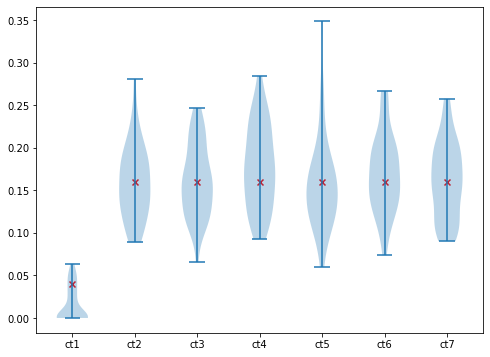

In [92]:
plt.figure(figsize=(8,6))
plt.scatter(x=[1,2,3,4,5,6,7], y= u,c="red",marker="x")
plt.violinplot(data_simu_prop)
plt.xticks([1,2,3,4,5,6,7],["ct"+str(i+1) for i in range(7)])


In [93]:
df_props_DM = pd.DataFrame(props_DM)
df_props_DM.columns = np.array(["ct"+str(i+1) for i in range(7)])

df_props_mean = pd.DataFrame(props_mean)
df_props_mean.columns = np.array(["ct"+str(i+1) for i in range(7)])

df_props_sum = pd.DataFrame(props_sum)
df_props_sum.columns = np.array(["ct"+str(i+1) for i in range(7)])

tmp = (pd.concat([d.assign(data=i)                       # assign adds the column `data` with values i
                    for i,d in enumerate([df_props_DM,df_props_mean,df_props_sum])]  # enumerate gives you a generator of pairs (0,df), (1,df1), (2,df2)
                )
         .melt(id_vars='data')                           # melt basically turns `id_vars` columns into index, 
                                                         # and stacks other columns
      )
tmp.loc[tmp.data==0,'data']="D-M"
tmp.loc[tmp.data==1,'data']="Mean"
tmp.loc[tmp.data==2,'data']="Sum"

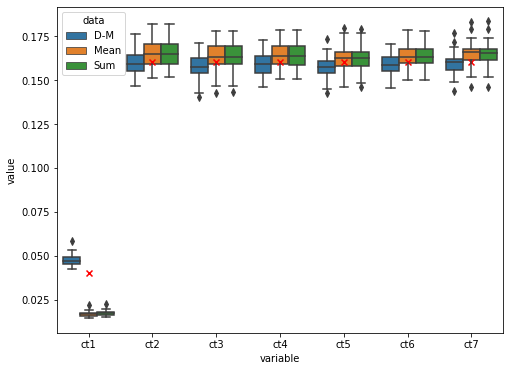

In [97]:
plt.figure(figsize=(8,6))
sns.boxplot(data=tmp, x='variable', hue='data', y='value')
plt.scatter(x=["ct"+str(i+1) for i in range(7)], y= u,c="red",marker="x")
plt.savefig("ExperimentResult/EX2/abundance/low.abundance.pdf",dpi=300)

In [96]:
props_reference = np.array([u for _ in range(50)])

print("correlation of Dirichlet-Multinomial model results：",mean_corrcoef(props_reference,props_DM))
print("correlation of mean proportions：",mean_corrcoef(props_reference,props_mean))
print("correlation of sum count proportion：",mean_corrcoef(props_reference,props_sum))

correlation of Dirichlet-Multinomial model results： 0.9896328344097439
correlation of mean proportions： 0.9925641000323256
correlation of sum count proportion： 0.9925542173174278


## 2.4 filtering proportions (how many samples with filtering)

In [104]:
u = np.array([0.3, 0.3, 0.08, 0.08, 0.08, 0.08, 0.08])# The first cell type will be filtered
Beta = np.ones((50,7))

sigma = np.eye(7)
for i in range(7):
    sigma[i,i] = abs(np.log(u[i])*0.5)

props_DM = np.zeros([50,7,6])
props_mean = np.zeros([50,7,6])
props_sum = np.zeros([50,7,6])

filter_index = [0,5,10,20,30,40]
for j in range(6):
    M = np.ones((50,7))
    M[0:filter_index[j],0] = 0
    
    for epoch in range(50):
        data_simu = generat_data_MVN(u,sigma,M,Beta,n_samples=50, lambda_poisson = 5000,gaussian_noise_parameter=0.05)

        # Estimate proportion with DM
        alpha_result = fit_DM(data_simu,M)
        props_DM[epoch,:,j] = (alpha_result/torch.sum(alpha_result)).detach().numpy()

        # directly calculate proportion
        props_mean[epoch,:,j] = np.array([x/sum(x) for x in data_simu]).mean(axis=0)
        props_sum[epoch,:,j] = data_simu.sum(axis=0)/data_simu.sum().sum()

In [105]:
MAE_DM_list = np.array([mean_absolute_error(np.array([u for i in range(50)]),props_DM[:,:,i]) for i in range(6)])
MAE_mean_list = np.array([mean_absolute_error(np.array([u for i in range(50)]),props_mean[:,:,i]) for i in range(6)])
MAE_sum_list = np.array([mean_absolute_error(np.array([u for i in range(50)]),props_sum[:,:,i]) for i in range(6)])

In [106]:
MSE_DM_list = np.array([mean_squared_error(np.array([u for i in range(50)]),props_DM[:,:,i]) for i in range(6)])
MSE_mean_list = np.array([mean_squared_error(np.array([u for i in range(50)]),props_mean[:,:,i]) for i in range(6)])
MSE_sum_list = np.array([mean_squared_error(np.array([u for i in range(50)]),props_sum[:,:,i]) for i in range(6)])

In [107]:
corrcoef_DM_list = np.array([mean_corrcoef(np.array([u for i in range(50)]),props_DM[:,:,i]) for i in range(6)])
corrcoef_mean_list = np.array([mean_corrcoef(np.array([u for i in range(50)]),props_mean[:,:,i]) for i in range(6)])
corrcoef_sum_list = np.array([mean_corrcoef(np.array([u for i in range(50)]),props_sum[:,:,i]) for i in range(6)])

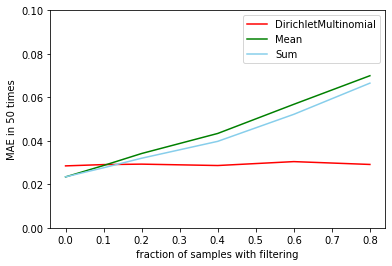

In [114]:
filter_index = np.array([0,5,10,20,30,40])/50


plt.figure()
plt.plot(filter_index, MAE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(filter_index, MAE_mean_list, color='green', label='Mean')
plt.plot(filter_index, MAE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.ylim(0,0.1)
plt.xlabel('fraction of samples with filtering')
plt.ylabel('MAE in 50 times')
plt.savefig("ExperimentResult/EX2/Filtering_sample_number/MAE.pdf",dpi=300)

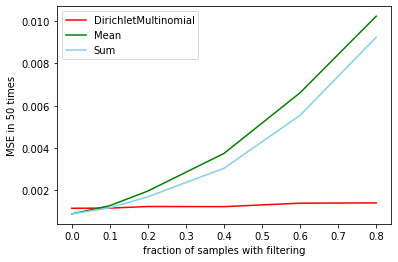

In [115]:
plt.figure()
plt.plot(filter_index, MSE_DM_list, color='red', label='DirichletMultinomial')
plt.plot(filter_index, MSE_mean_list, color='green', label='Mean')
plt.plot(filter_index, MSE_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.xlabel('fraction of samples with filtering')
plt.ylabel('MSE in 50 times')
plt.savefig("ExperimentResult/EX2/Filtering_sample_number/MSE.pdf",dpi=300)

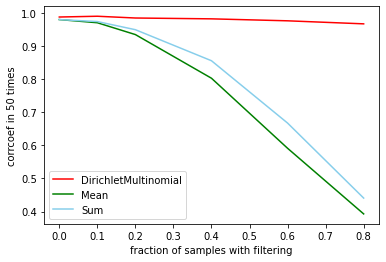

In [116]:
plt.figure()
plt.plot(filter_index, corrcoef_DM_list, color='red', label='DirichletMultinomial')
plt.plot(filter_index, corrcoef_mean_list, color='green', label='Mean')
plt.plot(filter_index, corrcoef_sum_list, color='skyblue', label='Sum')
plt.legend()
plt.xlabel('fraction of samples with filtering')
plt.ylabel('corrcoef in 50 times')
plt.savefig("ExperimentResult/EX2/Filtering_sample_number/Corrcoef.pdf",dpi=300)